In [17]:
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import warnings
from sklearn.cluster import KMeans




from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

As my PC took a long time to do create document_topic dataframe previously, i will use the .pkl file that was created to perform cluster analysis on 105-extracted-date to find the optimum number of clusters using the elbow methodology

In [18]:
document_topic = pd.read_pickle("document_topic.pkl")

In [19]:
document_topic

0        1         2         3         4         5         6
0   0.182821  0.00000  0.000000  0.000000  0.000000  0.000000  0.816740
1   0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.999623
2   0.000000  0.99961  0.000000  0.000000  0.000000  0.000000  0.000000
3   0.000000  0.00000  0.000000  0.000000  0.999602  0.000000  0.000000
4   0.000000  0.04382  0.000000  0.886328  0.069704  0.000000  0.000000
..       ...      ...       ...       ...       ...       ...       ...
94  0.344407  0.00000  0.000000  0.575140  0.000000  0.033037  0.047279
95  0.000000  0.00000  0.000000  0.854257  0.000000  0.000000  0.133699
96  0.414241  0.00000  0.000000  0.012511  0.000000  0.000000  0.570660
97  0.999317  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000
98  0.977867  0.00000  0.021119  0.000000  0.000000  0.000000  0.000000

[99 rows x 7 columns]

Checking first with the range(10, 100, 10) to see whole sample:

Text(0, 0.5, 'WCSS')

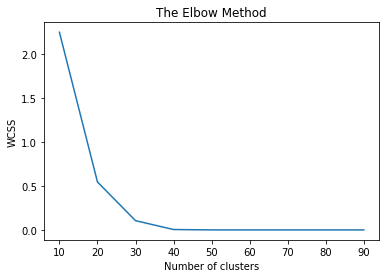

In [20]:
wcss = []
for i in range(10, 100, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 123456)
    kmeans.fit(document_topic)
    wcss.append(kmeans.inertia_)
plt.plot(range(10, 100, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


It seems there is a elbow corner within 10 clusters:

Text(0, 0.5, 'WCSS')

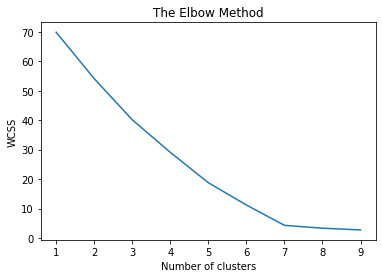

In [23]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 123456)
    kmeans.fit(document_topic)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


After 7 clusters there is not much sense, so this is the optimum number of clusters.

In [24]:
def format_congress_text(text_list):
    df = pd.DataFrame(text_list, columns=["text_raw"])

    df["text_raw"] = df["text_raw"].str.split("\n</TEXT>\n</DOC>\n\n<DOC>\n<DOCNO>")

    df = df.explode("text_raw")

    df["text_raw"] = df["text_raw"].str.replace("<DOC>\n<DOCNO>", "")

    df["meta"] = df["text_raw"].str.split("</DOCNO>\n<TEXT>\n").str[0]
    df["congress"] = df["meta"].str[:3]
    df["speaker"] = df["meta"].str.split("-").str[1]
    df["state"] = df["meta"].str.split("-").str[2]
    df["date"] = df["meta"].str.split("-").str[4]

    df["text_raw"] = (
        df["text_raw"]
        .str.split("</DOCNO>\n<TEXT>\n")
        .str[1]
        .str.strip()
        .str.split(".")
        .str[2:]
        .str.join(sep="")
        .str.strip()
    )

    df["text_raw"] = df["text_raw"] + " "

    # now join this back to congress / speaker level

    df = df.groupby(["congress", "speaker"])["text_raw"].sum().reset_index()

    # drop if a congressman did not speek
    df = df.loc[lambda x: x["text_raw"].apply(type) == str]
    return df

In [25]:
import os 
os.getcwd()

'C:\\Users\\molda\\Downloads'

In [26]:
droplist = open("ML-for-NLP-main/Inputs/droplist.txt", encoding="utf-8", newline="\n").read()
droplist = [i.replace('"', "") for i in droplist.split("\n")]
stop_words = stopwords.words("english")
stopwords_final = droplist + stop_words + ['s','nt', "n't"]

In [27]:
text_106 = [
    open("ML-for-NLP-main/Inputs/106-extracted-date/" + i, encoding="latin").read()
    for i in os.listdir("ML-for-NLP-main/Inputs/106-extracted-date/")
]

df_106 = format_congress_text(text_106)

In [28]:
def preprocessing_text(text):
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in string.punctuation]
    tokens = [token for token in tokens if token not in stopwords_final]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

In [29]:
vectorizer = TfidfVectorizer(preprocessor = preprocessing_text)
dtm_tfidf_106 = vectorizer.fit_transform(df_106["text_raw"])
df_tfidf_106 = pd.DataFrame(dtm_tfidf_106.toarray(), columns=vectorizer.get_feature_names())

In [31]:
df_tfidf_106.to_pickle("tfidf_106.pkl")

In [32]:
from gensim import models
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import re
import numpy as np
from gensim import corpora

In [33]:
tokenizer = RegexpTokenizer(r'\w+')
def prepare_text_for_lda(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [34]:
df_106['tokens'] = df_106['text_raw'].apply(lambda x: prepare_text_for_lda(x))

In [35]:
df_106.head()

congress   speaker                                           text_raw  \
0      106   abraham  Mr President, today I rise to comment on a dev...   
1      106     akaka  Mr President, I rise today to call my colleagu...   
2      106    allard  Mr President, the wonderful tree currently gra...   
3      106  ashcroft  Mr President, I would like to take this opport...   
4      106    baucus  Although I am unable to vote for or against th...   

                                              tokens  
0  [mr, president, today, i, rise, to, comment, o...  
1  [mr, president, i, rise, today, to, call, my, ...  
2  [mr, president, the, wonderful, tree, currentl...  
3  [mr, president, i, would, like, to, take, this...  
4  [although, i, am, unable, to, vote, for, or, a...

In [36]:
from nltk.corpus import wordnet
# original example can be found here https://stackoverflow.com/a/15590384

def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [37]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

In [38]:
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos = wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

def convert(list_element):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in stopwords_final]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

In [39]:
df_106['tokens'] = df_106['tokens'].progress_apply(lambda sentences: convert(sentences))

  0%|          | 0/99 [00:00<?, ?it/s]

In [40]:
df_106['tokens'].to_pickle("lda_prep_text106.pkl")

In [41]:
df_106["tokens"] = pd.read_pickle("lda_prep_text106.pkl")

In [42]:
df_106.head()

congress   speaker                                           text_raw  \
0      106   abraham  Mr President, today I rise to comment on a dev...   
1      106     akaka  Mr President, I rise today to call my colleagu...   
2      106    allard  Mr President, the wonderful tree currently gra...   
3      106  ashcroft  Mr President, I would like to take this opport...   
4      106    baucus  Although I am unable to vote for or against th...   

                                              tokens  
0  [president, rise, comment, development, week, ...  
1  [president, rise, call, colleague, attention, ...  
2  [president, wonderful, tree, currently, grace,...  
3  [president, opportunity, recognize, honor, mon...  
4  [unable, vote, omnibus, legislation, senate, c...

In [43]:
def get_LDA_model(df_106, num_topics=7):

    dictionary_LDA = corpora.Dictionary(df_106["tokens"].tolist())
    dictionary_LDA.filter_extremes(no_below=3)

    corpus = [dictionary_LDA.doc2bow(tok) for tok in df_106["tokens"].tolist()]

    np.random.seed(123)

    lda_model = models.LdaModel(
        corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4
    )
    return lda_model, corpus, dictionary_LDA

In [45]:
lda_model, corpus, dictionary_LDA = get_LDA_model(df_106,7)

In [61]:
num_topics = 7
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.003*"afterschool" + 0.002*"superfund" + 0.002*"osha" + 0.002*"mtbe" + 0.002*"handgun" + 0.001*"pesticide" + 0.001*"saddam" + 0.001*"prostate" + 0.001*"salmon" + 0.001*"fisherman" + 0.001*"drilling" + 0.001*"recycle" + 0.001*"wade" + 0.001*"palestinian" + 0.001*"paez" + 0.001*"organ" + 0.001*"pediatric" + 0.001*"brady" + 0.001*"bonnie" + 0.001*"debtor"

1: 0.003*"cuban" + 0.002*"mtbe" + 0.002*"apparel" + 0.002*"castro" + 0.002*"saharan" + 0.002*"creditor" + 0.002*"clip" + 0.001*"debtor" + 0.001*"ammunition" + 0.001*"methamphetamine" + 0.001*"bomber" + 0.001*"soybean" + 0.001*"hawaiian" + 0.001*"reit" + 0.001*"palestinian" + 0.001*"ethanol" + 0.001*"bottle" + 0.001*"serbian" + 0.001*"armor" + 0.001*"pill"

2: 0.004*"osha" + 0.004*"timor" + 0.003*"milk" + 0.002*"arbitration" + 0.002*"indonesia" + 0.002*"hornet" + 0.002*"miner" + 0.002*"cheese" + 0.002*"indonesian" + 0.002*"militia" + 0.001*"subsidiary" + 0.001*"alamo" + 0.001*"mexican" + 0.001*"ballot" + 0.001*"santa" + 0.001*"landlo

In [47]:
from gensim.models import Phrases
documents = df_106.text_raw

sentence_stream = [doc.split(" ") for doc in documents]
bigram = Phrases(sentence_stream, min_count=1, threshold=2)

In [48]:
sentence_stream

[['Mr',
  'President,',
  'today',
  'I',
  'rise',
  'to',
  'comment',
  'on',
  'a',
  'development',
  'that',
  'took',
  'place',
  'in',
  'my',
  'State',
  'this',
  'week',
  'It',
  'was',
  'with',
  'great',
  'sadness',
  'that',
  'I',
  'heard',
  'of',
  'the',
  'phasing',
  'out',
  'of',
  'the',
  'Oldsmobile',
  'line',
  'of',
  'cars',
  'within',
  'the',
  'General',
  'Motors',
  'family',
  'Over',
  'the',
  'last',
  '105',
  'years,',
  'Oldsmobile',
  'has',
  'been',
  'a',
  'Lansing,',
  'MI,',
  'and',
  'a',
  'State',
  'institution',
  'and,',
  'obviously,',
  'a',
  'national',
  'and',
  'international',
  'one',
  'as',
  'well',
  'It',
  'was',
  'started',
  '105',
  'years',
  'ago',
  'when',
  'Ransom',
  'Eli',
  'Olds',
  'of',
  'Lansing,',
  'MI,',
  'teamed',
  'with',
  'Frank',
  'Clark,',
  'the',
  'son',
  'of',
  'a',
  'small',
  'carriage',
  'shop',
  'operator,',
  'to',
  'achieve',
  'what',
  'many',
  'believed',
  'im

In [49]:
topics = [lda_model[corpus[i]] for i in range(99)]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [50]:
document_topic2 = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]).reset_index(drop=True).fillna(0)

In [51]:
document_topic2.to_pickle("document_topic2.pkl")

In [52]:
document_topic2.sort_values(2, ascending=False)[2].head(20)

33    0.999935
28    0.999899
32    0.999754
83    0.999746
80    0.999688
18    0.999664
11    0.999532
16    0.996621
71    0.987692
78    0.953170
15    0.858473
56    0.777126
44    0.424206
47    0.331308
76    0.321463
58    0.318075
49    0.211510
91    0.060457
2     0.022005
86    0.021438
Name: 2, dtype: float64

<AxesSubplot:>

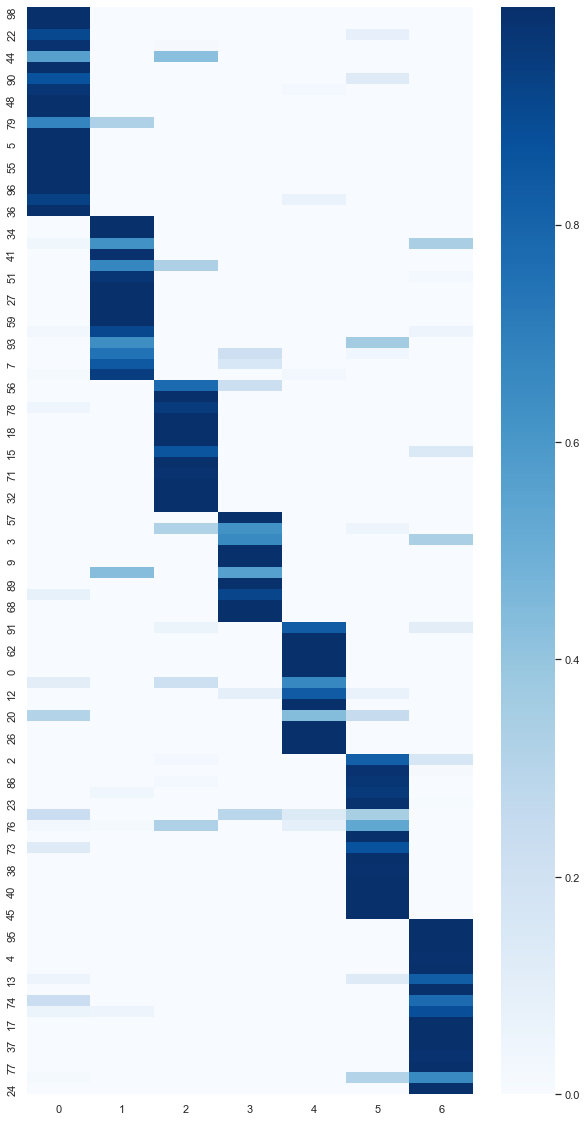

In [54]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic2.loc[document_topic2.idxmax(axis=1).sort_values().index], cmap="Blues")

<AxesSubplot:>

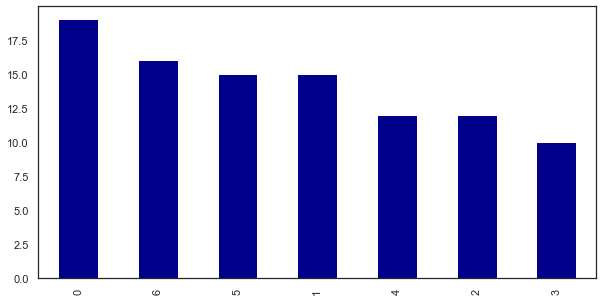

In [55]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white") 
document_topic2.idxmax(axis=1).value_counts().plot.bar(color='darkblue')

In [60]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis2 = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.display(vis2)

**The above diagram consists of two parts, the intertopic distance map on the left and the bar chart on the right. The area of the topic circles is proportional to the number of words belonging to each topic in the dictionary, so we can visually see that topics 1, 2, and 3 are the largest topics in the data, while topic 7 is the smallest topic in the data.**

The highest weight in topic 0 is "afterschool" and by looking through the heatmap and finding the document including this word it seems that it is about education initiatives and "superfund" programs. Topic 1 is probably about Cuba, (Fidel) Castro, drug trafficking and terrorism. Topic 2 covers mostly OSHA (Occupational Safety and Health Administration) ergonomics, (East) Timor (country in south-east Asia). Topic 3 seems to be a mixture, but "milk" has the highest weight, although it is not really a milk but frequency for different meaning including Harvey Milk (doc 57), normal milk and Milky Way. Topic 4 is about Detroit and organ transplantation mostly. Topic 5 is about normal milk as can be seen from document 86 and (court) vacancy (doc 38). Topic 6 is similar to the topic we had with 105-extracted-date which covered many not really related things like salmon(fishery) and microsoft. 

As described above there were topics similar to the ones covered in 105-extracted-date, however there were also new topics as well.

In [62]:
num_topics = 7
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.003*"afterschool" + 0.002*"superfund" + 0.002*"osha" + 0.002*"mtbe" + 0.002*"handgun" + 0.001*"pesticide" + 0.001*"saddam" + 0.001*"prostate" + 0.001*"salmon" + 0.001*"fisherman" + 0.001*"drilling" + 0.001*"recycle" + 0.001*"wade" + 0.001*"palestinian" + 0.001*"paez" + 0.001*"organ" + 0.001*"pediatric" + 0.001*"brady" + 0.001*"bonnie" + 0.001*"debtor"

1: 0.003*"cuban" + 0.002*"mtbe" + 0.002*"apparel" + 0.002*"castro" + 0.002*"saharan" + 0.002*"creditor" + 0.002*"clip" + 0.001*"debtor" + 0.001*"ammunition" + 0.001*"methamphetamine" + 0.001*"bomber" + 0.001*"soybean" + 0.001*"hawaiian" + 0.001*"reit" + 0.001*"palestinian" + 0.001*"ethanol" + 0.001*"bottle" + 0.001*"serbian" + 0.001*"armor" + 0.001*"pill"

2: 0.004*"osha" + 0.004*"timor" + 0.003*"milk" + 0.002*"arbitration" + 0.002*"indonesia" + 0.002*"hornet" + 0.002*"miner" + 0.002*"cheese" + 0.002*"indonesian" + 0.002*"militia" + 0.001*"subsidiary" + 0.001*"alamo" + 0.001*"mexican" + 0.001*"ballot" + 0.001*"santa" + 0.001*"landlo

<AxesSubplot:>

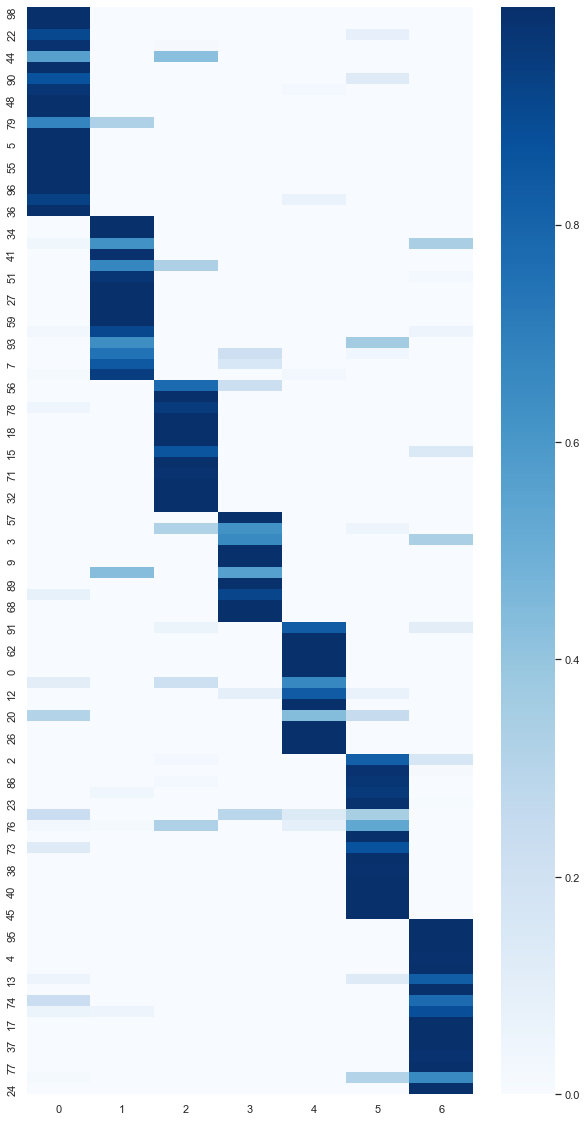

In [63]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic2.loc[document_topic2.idxmax(axis=1).sort_values().index], cmap="Blues")

In [65]:
df_106["text_raw"][96]

'I wholeheartedly agree with my colleague, Senator DEWINE I do not think we can stress enough that this really is a matter of survival for these companies and their employees The government bears some responsibility here, we simply must get this bill done as soon as possible The companies, their workers, and asbestos victims--after all when the companies go bankrupt it affects payments to victims--need certainty that this will be brought to the Senate floor at the earliest possible date next year We need to work to keep these companies afloat Mr President, today is November 1st, one month after the beginning of the new fiscal year and less than one week before the 2000 elections Most of us in this body had anticipated that by now, we would be home in our respective states instead of here in Washington However, we are once again in the midst of gridlock with a President who, despite his eight years in office, still does not understand how to delineate the proper role of government at th

In [66]:
df_106["text_raw"][9]

'The distinguished chairman of the Appropriations Committee is correct That reference is specifically intended to refer to Catholic Social Services for renovations and construction at the Brother Francis Shelter and AWAIC\'s transitional housing and was inadvertently referred to as Catholic Community Services I hope the RECORD will reflect this clarification and will result in an expeditious use of the funds Mr President, might I ask the indulgence of my good friend from Florida to take perhaps 5 minutes Mr President, I thank my former gubernatorial colleague There are far too few of us former Governors in this body, and it was my pleasure to serve with the Governor from Florida, who is now the Senator from Florida \n   It is a very melancholy time for me to rise today to pay my respects and honor and to offer sincerest thanks to a friend who is probably my closest colleague in politics We have been through a lot together I lost a couple races as well as winning some I can tell you, it

In [67]:
df_106["text_raw"][57]

"Mr President, I thank the Senator from New Jersey He is very gracious in doing so I know he wants to make some important comments that summarize his 18 years of work and commitment on this issue He is generous to allow us to intervene \n   I join in thanking the majority leader and the minority leader, Senator DASCHLE, Senator REID, particularly Senator BYRD and Senator STEVENS for responding to the request of a number of us from our region I thank Senator BIDEN and Senator LAUTENBERG for their leadership again on this issue \n   There was a lot of passion in our caucus earlier this afternoon, and the minority leader listened to all of us very carefully Our caucus, I must say, was united in its commitment to the notion that those of us who cared about this issue needed to have some kind of response on the floor that indicated where we will go I am grateful for this response \n   The commitment on the floor openly, as it has been given, to proceed as we will proceed, particularly from 

In [70]:
df_106["text_raw"][86]

"Mr President, I thank Senator HATCH for his leadership on this bankruptcy bill and for shepherding it through the Judiciary Committee \n   I remember distinctly when we first began to discuss the problems of children, alimony and child support, the leadership and the firm position Senator HATCH took to guarantee that children and alimony payments would have an enhanced position in bankruptcy, much higher than it had ever been before That was the goal of Senator HATCH, who has worked on this bill and previous bankruptcy bills and studied this \n   I am looking at a letter from some professors who don't seem to get it But the Senator has studied and sponsored the amendment that made some of the historic changes \n   Is there any doubt in your mind, Senator, that the children will benefit from those child support payments, and women will have more protections for alimony payments under this bill that we are about to pass than if the bill does not pass? Mr President, we have had quoted on

In [71]:
df_106["text_raw"][38]

'The distinguished chairman of the Appropriations Committee is correct That reference is specifically intended to refer to the Swan Lake-Tyee Intertie project and was inadvertently referred to as the southeast Alaska intertie I hope the RECORD  will reflect this clarification and will result in an expeditious use of the funds \n   LIHEAP Mr President, I suggest the absence of a quorum Mr President, I ask unanimous consent that the order for the quorum call be rescinded Mr President, yesterday morning, without any notice to this Senator, my distinguished colleague from Washington, Senator MURRAY, came to the floor to congratulate me in my career in the Senate in a most generous and gracious fashion and to yield time to other Senators for the same purpose \n   Each of them, including the other Senator present, Mr BURNS, was more than generous and profuse in their praise The experience of listening to it in my office bore some resemblance to attending one\'s own wake But, nonetheless, the

In [56]:
document_topic2

0    1         2         3         4         5         6
0   0.000000  0.0  0.000000  0.000000  0.999068  0.000000  0.000000
1   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.999727
2   0.000000  0.0  0.022005  0.000000  0.000000  0.813419  0.160260
3   0.000000  0.0  0.000000  0.654926  0.000000  0.000000  0.334545
4   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.993660
..       ...  ...       ...       ...       ...       ...       ...
94  0.999726  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
95  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.997245
96  0.999717  0.0  0.000000  0.000000  0.000000  0.000000  0.000000
97  0.000000  0.0  0.000000  0.999943  0.000000  0.000000  0.000000
98  0.999750  0.0  0.000000  0.000000  0.000000  0.000000  0.000000

[99 rows x 7 columns]

Text(0, 0.5, 'WCSS')

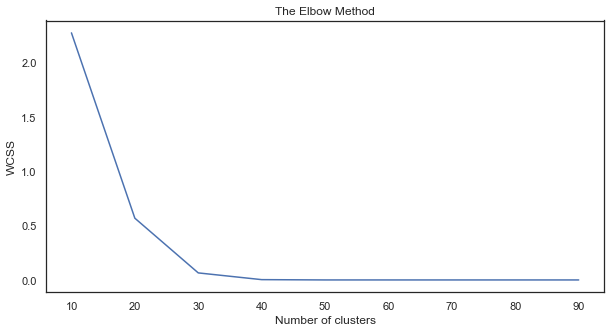

In [57]:
wcss = []
for i in range(10, 100, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 123456)
    kmeans.fit(document_topic2)
    wcss.append(kmeans.inertia_)
plt.plot(range(10, 100, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


It seems there is a elbow corner within 10 clusters:

Text(0, 0.5, 'WCSS')

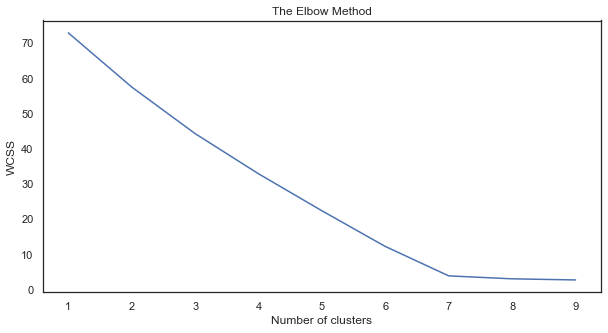

In [59]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 123456)
    kmeans.fit(document_topic2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


Similarly to the 105-extracted-date, optimum cluster number is 7